# Baechi

In [1]:
import torch
import torchvision
from torchvision import models
import time
import networkx as nx
from torch import optim, nn
from importlib import reload
import numpy as np
import pickle

import GPUtil

import sys


## Copy of Inceptionv3, slightly modified for recording intermeridates
sys.path.append('/home/cshetty2/sct/pytorch')
import reformated_models.inception_modified as inception_modified

## Modified Alexnet, with a'factor' by which it can be made 'fat' 
import simple_model as sm

######## For profiler (some experiments. Not required) #################
from torch.profiler import profile, record_function, ProfilerActivity


## Placer libs of baechi
sys.path.append('/home/cshetty2/sct')
from placer.placer_lib import *

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Basic Setup

### Arguments passed (usually from the command line)

In [2]:
## Defined in this round about way (instead of just directly assigning) to keep it compatibble with summarize.py
class Args:
     def __init__(self,itype, prof_rounds, prof_gpu_id, batch_size, gpu_num, sch):
         self.type = itype
         self.prof_rounds = prof_rounds
         self.prof_gpu_id = prof_gpu_id
         self.batch_size = batch_size
         self.gpu_num = gpu_num
         self.sch = sch
            
itype       = 'forward'  # help: forward/all -> Conside forward path only or both
prof_rounds = 40      # help: 'rounds for profiler'
prof_gpu_id = 3      # help: 'which gpu to place the profiler'
batch_size  = '128'   # help: 'batch_size'
gpu_num     = 3      # help: 'number of gpu to use'
sch         = 'sct'  # help: 'sct/etf/topo'

args = Args(itype, prof_rounds, prof_gpu_id, batch_size, gpu_num, sch)

### Device (4 GPU) Setup

In [3]:
"""
    Function: placer_lib.create_device_graph
    -> Creates a graph with devices as nodes and unit weight edges between them
    -> Each node: graph.add_node(device_id,
                                 id=device_id,
                                 name=device_info["name"],
                                 size=0,
                                 memory_limit=device_info["memory_size"])
"""
DEVICE_GRAPH_SINGLE = create_device_graph({0: {'name': '/job:localhost/replica:0/task:0/device:XLA_GPU:0', 'memory_size':  17179869184, 'type': ''}})
DEVICE_GRAPH_MULTIPLE = create_device_graph({0: {'name': '/job:localhost/replica:0/task:0/device:XLA_GPU:0', 'memory_size': 8000000000, 'type': ''}, 
                                             1: {'name': '/job:localhost/replica:0/task:0/device:XLA_GPU:1', 'memory_size': 8000000000, 'type': ''}, 
                                             2: {'name': '/job:localhost/replica:0/task:0/device:XLA_GPU:2', 'memory_size': 8000000000, 'type': ''}, 
                                             3: {'name': '/job:localhost/replica:0/task:0/device:XLA_GPU:3', 'memory_size': 8000000000, 'type': ''}})


device_list = {0: {'name': '/job:localhost/replica:0/task:0/device:XLA_GPU:0', 'memory_size': 8000000000, 'type': ''}, 
               1: {'name': '/job:localhost/replica:0/task:0/device:XLA_GPU:1', 'memory_size': 8000000000, 'type': ''}, 
               2: {'name': '/job:localhost/replica:0/task:0/device:XLA_GPU:2', 'memory_size': 8000000000, 'type': ''}, 
               3: {'name': '/job:localhost/replica:0/task:0/device:XLA_GPU:3', 'memory_size': 8000000000, 'type': ''}}

In [4]:
"""
    we are going to use streams to allow parallel processing
"""
COMPUTE0 = torch.cuda.Stream(device=0)
COMPUTE1 = torch.cuda.Stream(device=1)
COMPUTE2 = torch.cuda.Stream(device=2)
COMPUTE3 = torch.cuda.Stream(device=3)
COMPUTE_STREAM = {0:COMPUTE0,1:COMPUTE1,2:COMPUTE2,3:COMPUTE3}

### Utilities

In [5]:
## Print memory of all available GPU's
def print_gpu_memory():
    for i in range(torch.cuda.device_count()):
        #print(torch.cuda.get_device_name(i))
        print("GPU:", i)
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(i)/1024**3,8), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(i)/1024**3,8), 'GB')
        #print("-----------------")
        #GPUtil.showUtilization()
        print("-----------")

# print memory of given GPU. ex: gpu_no = 0
def print_mem(gpu_id, cached=2, unit='GB'):
    if unit=='GB':
        mem_allocated = round(torch.cuda.memory_allocated(gpu_id)/1024**3,8)
        mem_cached    = round(torch.cuda.memory_reserved(gpu_id)/1024**3,8)
    else:
        mem_allocated = torch.cuda.memory_allocated(gpu_id)
        mem_cached    = torch.cuda.memory_reserved(gpu_id)
        
    if cached>0:
        print('Allocated:', mem_allocated , 'GB')
    if cached>1:
        print('Cached:   ', mem_cached    , 'GB')
    return mem_allocated, mem_cached


In [6]:
# Get the leaf operations in a model. model.modules() gives not just the leaves, bbut higher levels as well
# Ref: https://stackoverflow.com/questions/54846905/pytorch-get-all-layers-of-model
# More explanation: https://discuss.pytorch.org/t/module-children-vs-module-modules/4551/4
def get_children(model: torch.nn.Module):
    # get children form model!
    children = list(model.children())
    flatt_children = {}
    if children == []:
        # if model has no children; model is last child! :O
        return {id(model): model}
    else:
       # look for children from children... to the last child!
       for child in children:
            try:
                flatt_children.update(get_children(child))
            except TypeError:
                flatt_children.update(get_children(child))
    return flatt_children

# Profiling

### Utilities

In [7]:
def b2gb(x): return round(x/2**30,8)
class TorchTracemalloc():
    def __init__(self, gpu_id):
        self.gpu_id = gpu_id

    def __enter__(self):
        self.begin = torch.cuda.memory_allocated(self.gpu_id)
        torch.cuda.reset_max_memory_allocated(self.gpu_id) # reset the peak gauge to zero
        return self

    def __exit__(self, *exc):
        self.end  = torch.cuda.memory_allocated(self.gpu_id)
        self.peak = torch.cuda.max_memory_allocated(self.gpu_id)
        self.used   = (self.end-self.begin)
        self.peaked = (self.peak-self.begin)

#### Estimate size of the model (in GB or MB or )

def estimate_model_size(model, unit='MB', to_print = True): 
    persistent_memory = 0
    for name, param in model.named_parameters():
        persistent_memory += param.element_size() * param.nelement()
    if unit == 'GB':
        gb_mem = round(persistent_memory/1024**3,8)
        if to_print:
            print("Estimated Model Memory:",gb_mem, "GB")
        return gb_mem
    elif unit == 'B':
        gb_mem = persistent_memory
        if to_print:
            print("Estimated Model Memory:",gb_mem, "Bytes")
        return gb_mem
    else:
        mb_mem = round(persistent_memory/1024**2,8)
        if to_print:
            print("Estimated Model Memory:", mb_mem, "MB")
        return mb_mem
    
def estimate_tensor_size(inp, unit='B'):
    input_size = 0
    if isinstance(inp, torch.Tensor): 
        input_size += float(torch.prod(torch.tensor(inp.size())))
    if isinstance(inp, list): 
        for sub_inp in inp:
            if isinstance(sub_inp, torch.Tensor): input_size += float(torch.prod(torch.tensor(sub_inp.size())))

    input_size = input_size*torch.rand((1,1)).element_size() # multiply by 4
    if unit == 'GB':
        gb_mem = round(input_size/1024**3,8)
        #print("Estimated Input/Output Memory:",gb_mem, "GB")
        return gb_mem
    if unit == 'B':
        gb_mem = input_size
        #print("Estimated Input/Output Memory:",gb_mem, "B")
        return gb_mem
    else:
        mb_mem = round(input_size/1024**2,8)
        #print("Estimated Input/Output Memory:", mb_mem, "MB")
        return mb_mem

## Profiler Main

SubModuleNode - Represent a node (layer) \
A layer here means the most basic units used to build a network in pytorch. Eg: Linear, Relu, Conv2d, maxpool etc 

Attributes: \
    - name \
    - parent \
    - children \
    - weight_forward =====> Forward runtime of the layer (in ms) \
    - weight_backward =====> Backward runtime of the layer (in ms) \
    - id_hash ====> Layers python id \
    - persistent_memory ====> Memory occupied by layer parameters \
    - input_memory ====> Size of input to the layer (in bytes) \
    - output_memory ====> Size of output of the layer (in bytes) \
    - temporary_memory ====> temporary memory used by the layers forward run \
    - p ====> GPU to which the layer is finally assigned 
    
To do:   
- Add temporary_memory for backward run
- Compute backward runtime

In [8]:
class SubModuleNode:
    """
    This class represents a submodel (ex. conv2d layer) in the given model (ex. inception_v3). 
    It is represented as a node in the return graph
    """
    def __init__(self):
        # store the entire submodel
        self.module = None
        # submodel name
        self.name = None

        # nodes that must finish processing before this node (direct dependencies)
        self.parent = set()
        # nodes that depends on this node
        self.children = set()

        # forward function's estimated runtime
        self.weight_forward = 0
        # backward function's estimated runtime
        self.weight_backward = 0
        # id represented by the model's location (python's id function)
        self.id_hash = None
        # sudo id used, for one model, this sudo id starts from 0 and add 1 for each new node
        # -- self.id = None
        # storage used by submodel's parameters (weight, bias)
        self.persistent_memory = 0
        # submodel's input's size
        self.input_memory = 0
        # submodel's output's size
        self.output_memory = 0
        # temporary memory used in forward run
        self.temporary_memory = 0
        
        # gpu assigned to the submodule
        self.p = None
       

Profiling - class that creates SubModuleNode nodes (one per layer) complete with all thhe profiling data

- run() method runs a dummy run of training loop and profiles each layer. First it calls recur_function() and then does training runs (first few iterations are ignored)
- Given a model, recur_function breaks it down to individual layers and replaces their forward function with forward wrapper which creates a SubModuleNode node containing:
    - average forward time
    - model, input, output and temporary memory requirements
- recur_function also adds to each layer:
    - backward hook which are later used to compute backward time
    - forward hook which modifies layer's output metadata to include the layer-name that created the output 
 

In [9]:
class Profiling:
    """
    This class produce the profile, this class referenced "https://github.com/msr-fiddle/pipedream"
    """
    def __init__(self, model, gpu=0, rounds=20, input_size=(3, 299, 299)):
        """
        model: ex. inception_v3 model, alexnet model, etc
        gpu: choose in between {0,1,2,3}
        rounds: number of rounds to run the profiling
        """
        self.gpu = gpu
        self.model = model.to(self.gpu)
        self.input_size = input_size

        self.rounds = rounds
        # first few rounds are inaccurate, so I choose to discard the results from the first 1/4 rounds
        self.ignore_rounds = int(self.rounds/4)
        # counting variable, runs from 0 - self.rounds
        self.cur_round = 0

        # used to calculate backward runtime for each submodule
        self.back_record = []
        # all submodules record of the form {id of the layer(submodule) : SubModuleNode created out of tha layer}
        self.sub_module_nodes = {}
        # use id_hash to record the order of submodules's execution
        self.submodule_order = []

        # internal use only, record the original forward functions for submodules
        self.forward_original_methods = {}
        # internal use only, switch back to the original forward functions after profiling
        self.detach_record = set()
        # Collect handles to all hooks added, so as to remove them in detach()
        self.hook_handles = []


    def recur_function(self, module):
        """
        modify self.model: adding forward timing, backward timing, input output sizes, etc
        :param module: the model to recursively add forward/backward wrappers to
        """
        this_profiler = self
        sub_modules = module.__dict__['_modules']
        for name, sub_module in sub_modules.items():
            # sub modules of sub_module, if there are more than 1, we need further recursion
            sub_sub_modules = sub_module.__dict__['_modules']
            if len(sub_sub_modules) > 0:
                self.recur_function(sub_module)
                continue
            
            def _calculate_time_and_memory(function, *input):
                """
                - Helper function in forward wrapper
                - Calculates forward runtime, peak memory used and static memory used
                - Verified: Memory measurement context doesn't add overhead to
                  time measurement
                """
                with TorchTracemalloc(self.gpu) as tt:
                    torch.cuda.synchronize(self.gpu)
                    start_time = time.time()
                    result = function(*input)
                    torch.cuda.synchronize(self.gpu)
                    stop_time = time.time()
                return (stop_time - start_time) * 1000, tt.used, tt.peaked , result

            def forward_wrapper(cur_module, *input):
                """
                use this wrapper to replace the original forward function in submodules
                :param cur_module: the input submodule
                """
                # original forward function
                
                function = this_profiler.forward_original_methods[cur_module]
                if this_profiler.cur_round < this_profiler.ignore_rounds:
                    if this_profiler.cur_round == 0:
                        # record submodule execution order only in the first round
                        print('-->', "Module name: ",cur_module)
                        this_profiler.submodule_order.append(id(cur_module))
                    # do not record first few rounds
                    result = function(*input)
                    return result
                
                ## collect relevant information of cur module
                forward_time, used_mem, peak_mem, result = _calculate_time_and_memory(function, *input)
                
                ## Input size in bytes
                input_size = 0
                for inp in input:
                    input_size = input_size + estimate_tensor_size(inp, 'B')
                
                ## Model size in bytes
                persistent_memory = estimate_model_size(cur_module,'B', False)

                output_memory = estimate_tensor_size(result, 'B')
                
                '''
                if not(used_mem==512*np.ceil(output_memory/512)):
                    print('*'*50)
                    print("In sumodule ", cur_module , ':' )
                    print("Output memory is: ", output_memory)
                    print("But used memory is: ", used_mem)
                    print("They dont match upto a factor of 512 (since mem bolcks are alotted in 512 byte locks) as expected")
                    print('*'*50)
                '''
                    
                temporary_memory = peak_mem - used_mem

                # record a SubModuleNode for each model layer
                if id(cur_module) not in this_profiler.sub_module_nodes:
                    cur_node = SubModuleNode()
                    cur_node.id_hash = id(cur_module)
                    cur_node.module = cur_module
                    cur_node.name = cur_module.__class__.__name__
                    
                    #***********?????????????????????????????????????????***************************
                    ########## REMOVE THIS ######################
                    cur_node.persistent_memory = persistent_memory
                    cur_node.temporary_memory = temporary_memory
                    cur_node.output_memory = output_memory
                    cur_node.input_memory = input_size
                    #############################################
                    #***********?????????????????????????????????????????***************************
                    
                    ### And Uncomment this
                    #cur_node.persistent_memory = persistent_memory
                    #cur_node.temporary_memory = temporary_memory
                    #cur_node.output_memory = output_memory
                    #cur_node.input_memory = input_size
                    
                else:
                    cur_node = this_profiler.sub_module_nodes[id(cur_module)]
                # we want weight_forward as the average forward runtime of the relevent rounds
                cur_node.weight_forward += forward_time / (this_profiler.rounds - this_profiler.ignore_rounds)
                this_profiler.sub_module_nodes[id(cur_module)] = cur_node

                return result

            def hook(cur_module, inputs, output):
                # this is for retriving the module inside make dot function
                output.grad_fn.metadata['module'] = cur_module

            def backward_post_hook(cur_module, input, output):
                """
                add backward hook to record backward runtime
                :param cur_module: the input submodule
                """
                if this_profiler.cur_round < this_profiler.ignore_rounds:
                    # do not record first few rounds
                    return
                torch.cuda.synchronize(0)
                cur_time = time.time() * 1000
                this_profiler.back_record.append((id(cur_module), cur_time))

            if sub_module in self.forward_original_methods:
                # only record the original forward functions once
                continue

            self.forward_original_methods[sub_module] = sub_module.forward
            sub_module.forward = forward_wrapper.__get__(sub_module, sub_module.__class__)
            fhook_handle = sub_module.register_forward_hook(hook)
            bhook_handle =  sub_module.register_backward_hook(backward_post_hook)
            this_profiler.hook_handles.append(fhook_handle)
            this_profiler.hook_handles.append(bhook_handle)
            
            
    def detach(self, module):
        """
        use this helper function to detach all forward wrappers
        """
        this_profiler = self
        sub_modules = module.__dict__['_modules']
        for name, sub_module in sub_modules.items():
            sub_sub_modules = sub_module.__dict__['_modules']
            if len(sub_sub_modules) > 0:
                self.detach(sub_module)
                continue
            if sub_module in self.detach_record:
                continue

            self.detach_record.add(sub_module)
            sub_module.forward = self.forward_original_methods[sub_module]
        ## Remove all the hooks that were added
        for handle in this_profiler.hook_handles:
            handle.remove()

    def run(self):
        """
        :return: the model's output of the final round
        """
        self.sub_module_nodes = {}
        self.recur_function(self.model)

        # create a fake dataset, we don't care about accuracy.
        dataset = torchvision.datasets.FakeData(
            size=self.rounds * int(args.batch_size),
            #image_size=(3, 299, 299),
            image_size = self.input_size,
            num_classes=1000,
            transform=torchvision.transforms.ToTensor())
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=int(args.batch_size))

        # this is the output of the final round
        last_output = None
        for batch_idx, (inp, oup) in enumerate(data_loader):
            self.cur_round = batch_idx
            # clear the record list
            self.back_record = []

            inp = inp.to(self.gpu); inp.requires_grad = True
            optimizer = optim.SGD(self.model.parameters(), lr = 0.0001); optimizer.zero_grad()
            criterion = nn.MSELoss()
            
            torch.cuda.synchronize(self.gpu)
            output = self.model(inp)
            torch.cuda.synchronize(self.gpu)
             
            
            ######################### loss compute ################################################
            try:
                loss = criterion(output, torch.randn(int(args.batch_size), len(output)).to(self.gpu))
            except:
                loss = criterion(output, torch.randn(int(args.batch_size), len(output[0])).to(self.gpu))
            ##################################################################################

            # add the start time of backward 
            self.back_record.append(('start', time.time() * 1000))
            if batch_idx == self.rounds - 1:
                #loss.backward(loss, retain_graph=True)
                loss.backward(loss)
                last_output = output
            else:
                loss.backward(loss)
            #print_mem(0,1)
            #print('*'*50)

            if batch_idx < self.ignore_rounds:
                continue
            else:
                # calculate the backward runtime for each layer by calculating the time differences between each timestamp
                for i in range(len(self.back_record) - 1, 0, -1):
                    now = self.back_record[i]
                    prev = self.back_record[i - 1]
                    cur_node = self.sub_module_nodes[now[0]]
                    cur_node.weight_backward += (now[1] - prev[1]) / (self.rounds - self.ignore_rounds)
                    self.sub_module_nodes[now[0]] = cur_node
        self.detach(self.model)
        return last_output
    

### Skip - Local Test ** ** ** ** ***** *** *** ***** ** **** ***** ***** ***

 ## ** ** *** *** *** ****** ******** ******* ****** ***** ******* ***** ***** ********

## Build the Graph

make_dot - create DiGraph nodes

In [10]:
def make_dot_original(var, cur_model):
    """
    this function build a DiGraph for the model, by tracing the grad function of each layer's output
    :return: the DiGraph
    """
    dot = nx.DiGraph()
    seen = set()
    output_nodes = (var.grad_fn,) if not isinstance(var, tuple) else tuple(v.grad_fn for v in var)

    def add_nodes(var):
        if var not in seen:
            cur_id = None
            if var.metadata != {}:
                # this submodule has a forward function, so it's information is previously recorded in Profiling
                cur_id = id(var.metadata['module'])
                # retrieve the node representing this submodule
                cur_node = cur_model.sub_module_nodes[id(var.metadata['module'])]
                dot.add_node(id(var.metadata['module']), 
                             model = str(cur_node.module), 
                             name = str(cur_node.name), 
                             weight=cur_node.weight_forward,
                             reverse_weight=cur_node.weight_backward,
                             id=id(var.metadata['module']), 
                             topo_order=id(var.metadata['module']), 
                             temporary_memory=cur_node.temporary_memory, 
                             persistent_memory=cur_node.persistent_memory,
                             output_memory=[cur_node.output_memory], 
                             output_tensors=cur_node.output_memory, 
                             colocation_group="")
            else:
                # this 'submodule' has no forward function, we assume that the forward runtime & backward runtime can be ignored
                cur_id = id(var)
                dot.add_node(id(var), 
                             model = None, 
                             name = str(type(var).__name__),
                             weight=0.000000001, 
                             reverse_weight=0.000000001,
                             id=id(var), 
                             topo_order=id(var),
                             temporary_memory=0, 
                             persistent_memory=0, 
                             output_memory=[0], 
                             output_tensors=0, 
                             colocation_group="")
                if cur_id not in cur_model.sub_module_nodes:
                    # should only occur once for the final output
                    represent_node = SubModuleNode()
                    represent_node.name = str(type(var).__name__)
                    represent_node.id_hash = cur_id
                    cur_model.sub_module_nodes[cur_id] = represent_node

            seen.add(var)

            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None and torch.is_tensor(u[0]) is False and hasattr(u[0], 'variable') is False:
                        next_id = id(u[0])
                        if u[0].metadata != {}: 
                            next_id = id(u[0].metadata['module'])
                        else:
                            # append a new node to model's record if not seen before
                            represent_node = SubModuleNode()
                            represent_node.name = str(type(u[0]).__name__)
                            represent_node.id_hash = id(u[0])
                            cur_model.sub_module_nodes[id(u[0])] = represent_node
                        cur_model.sub_module_nodes[next_id].children.add(cur_id)
                        cur_model.sub_module_nodes[cur_id].parent.add(next_id)
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    if torch.is_tensor(t) or hasattr(t, 'variable'): continue
                    next_id = id(t)
                    if t.metadata != {}:
                        next_id = id(t.metadata['module'])
                    else:
                        # append a new node to model's record if not seen before
                        represent_node = SubModuleNode()
                        represent_node.name = str(type(t).__name__)
                        represent_node.id_hash = id(t)
                        cur_model.sub_module_nodes[id(t)] = represent_node
                    cur_model.sub_module_nodes[next_id].children.add(cur_id)
                    cur_model.sub_module_nodes[cur_id].parent.add(next_id)
                    add_nodes(t)

    if isinstance(var, tuple):
        # handle multiple outputs
        for v in var:
            add_nodes(v.grad_fn)
    else:
        add_nodes(var.grad_fn)
    
    return dot

In [11]:
'''
make_dot is modified to add nodes for only the autograd corresponding to layers
'''

def make_dot(var, cur_model):
    """
    this function build a DiGraph for the model, by tracing the grad function of each layer's output
    :return: the DiGraph
    """
    dot = nx.DiGraph()
    seen = set()
    output_nodes = (var.grad_fn,) if not isinstance(var, tuple) else tuple(v.grad_fn for v in var)

    def add_nodes(var):
        print("Dealing with this variable:", var)
        if var not in seen:
            cur_id = None
            if var.metadata != {}:
                if ('module' in var.metadata):
                    # this submodule has a forward function, so it's information is previously recorded in Profiling
                    cur_id = id(var.metadata['module'])
                    # retrieve the node representing this submodule
                    cur_node = cur_model.sub_module_nodes[id(var.metadata['module'])]
                    dot.add_node(id(var.metadata['module']), 
                                 model = str(cur_node.module), 
                                 name = str(cur_node.name), 
                                 weight=cur_node.weight_forward,
                                 reverse_weight=cur_node.weight_backward,
                                 id=id(var.metadata['module']), 
                                 topo_order=id(var.metadata['module']), 
                                 temporary_memory=cur_node.temporary_memory, 
                                 persistent_memory=cur_node.persistent_memory,
                                 output_memory=[cur_node.output_memory], 
                                 output_tensors=cur_node.output_memory, 
                                 colocation_group="")
                    
                    if hasattr(var, 'next_functions'):
                        for u in var.next_functions:
                            if u[0] is not None and torch.is_tensor(u[0]) is False and hasattr(u[0], 'variable') is False:
                                if u[0].metadata != {}:
                                    if ('module' in u[0].metadata):
                                        next_id = id(u[0].metadata['module'])
                                        cur_model.sub_module_nodes[next_id].children.add(cur_id)
                                        cur_model.sub_module_nodes[cur_id].parent.add(next_id)
                                    elif ('parent' in u[0].metadata):
                                        u[0].metadata['parent'].add(cur_id)
                                    else:
                                        print("Error:", u[0], " has metadata that is neither module nor parent!")
                                        return 0
                                else:
                                    u[0].metadata['parent'] = set()
                                    u[0].metadata['parent'].add(cur_id)
                                    
                                add_nodes(u[0])
                                
                elif ('parent' in var.metadata):
                    cur_id_list = []
                    for parent in var.metadata['parent']:
                        cur_id_list.append(parent)
                    if hasattr(var, 'next_functions'):
                        for u in var.next_functions:
                            if u[0] is not None and torch.is_tensor(u[0]) is False and hasattr(u[0], 'variable') is False:
                                if u[0].metadata != {}:
                                    if ('module' in u[0].metadata):
                                        next_id = id(u[0].metadata['module'])
                                        for cur_id in cur_id_list:
                                            cur_model.sub_module_nodes[next_id].children.add(cur_id)
                                            cur_model.sub_module_nodes[cur_id].parent.add(next_id)
                                    elif ('parent' in u[0].metadata):
                                        for cur_id in cur_id_list:
                                            u[0].metadata['parent'].add(cur_id)
                                    else:
                                        print("Error:", u[0], " has metadata that is neither module nor parent!")
                                        return 0
                                else:
                                    u[0].metadata['parent'] = set()
                                    for cur_id in cur_id_list:
                                        u[0].metadata['parent'].add(cur_id)
                                add_nodes(u[0])
                
            else:
                ## All functions will have either 'module' or 'parent' metadata
                print('*'*100)
                print("Error:", var, " does not have any metadata!")
                print(var.__dict__)
                print('*'*100)
                return 0

            seen.add(var)

    if isinstance(var, tuple):
        # handle multiple outputs
        for v in var:
            add_nodes(v.grad_fn)
    else:
        add_nodes(var.grad_fn)
    
    return dot

Utilities required to build the graph

In [12]:
def topological_sort(model):
    """
    this helper function helps to generate the execution order based on dependecies
    """
    record = set()
    while len(record) < len(model.sub_module_nodes):
        root_helper = set(model.sub_module_nodes.keys()) - record
        reordered_root_helper = []
        for elem in model.submodule_order:
            if elem in root_helper:
                reordered_root_helper.append(elem)
        reordered_root_helper += list(root_helper - set(reordered_root_helper))
        for elem in root_helper:
            parents = model.sub_module_nodes[elem].parent
            if parents is None or len(parents - record) == 0:
                model.sub_module_nodes[elem].id = len(record)
                record.add(elem)

In [13]:

def copy_p(assigned_graph, model):
    """
    helper function to add .p field based on the assigned DiGraph 
    """
    for node_id in model.sub_module_nodes:
        model.sub_module_nodes[node_id].p = assigned_graph.nodes[model.sub_module_nodes[node_id].id]["p"]

        
def recursively_assign(Input, Device):
    """
    helper function to assign Input recursively to a gpu Device
    """
    result = None
    if isinstance(Input, list):
        result = []
        for elem in Input:
            result.append(recursively_assign(elem, Device))
    else:
        if Input.device.index != Device:
            result = Input.cuda(Device)
        else:
            result = Input
    return result


def print_assigned_graph(return_graph):
    """
    helper function to print where each layer is assigned to
    :param return_graph: assigned DiGraph
    """
    my_record = {}
    for node in return_graph.nodes(data=True):
        my_record[node[1]['topo_order']] = (node[1]['name'], node[1]['persistent_memory'], node[1]['weight'], node[1]['p'])

    for i in range(len(return_graph.nodes)):
        print(i, my_record[i])

### Test make_dot

Connect the DiGraph nodes created by make_dot

In [14]:
def build_graph(model, gpu=0, rounds=1, inp_size = (3,299,299)):
    """
    this is the main function to call for building the graph, it calls profiling and make dot, and made further improvements
    :param model: input model (ex. inception_v3)
    :param gpu: which gpu to place the profiler
    :param rounds: number of rounds to run the profiling
    :return: the DiGraph, and the Profiling object
    """
    print("Profiling started", '*'*20)
    tester = Profiling(model, gpu, rounds, input_size = inp_size)
    final_output = tester.run()
    
    print("make_dot started", '*'*20)
    return_graph = make_dot(final_output, tester)

    print("Sort topologically", '*'*20)
    topological_sort(tester)
    
    # use the sudo id instead of hash_id, this is for scheduler purpose
    print("Replacing sub module id", '*'*20)
    for node_id in tester.sub_module_nodes.keys():
        model_node = tester.sub_module_nodes[node_id]
        #if len(model_node.parent)==0 and len(model_node.children)==0:
        #    print('*'*50)
        #    print("Module defined but not used:")
        #    print(model_node.__dict__)
        #    print('*'*50)
        #else:
        graph_node = return_graph.nodes[node_id]
        graph_node["id"] = model_node.id
        graph_node["topo_order"] = model_node.id
        return_graph.add_nodes_from([(model_node.id, graph_node)])
        return_graph.remove_node(node_id)

    # since some 'sub module' have no forward function, we have limited data on them. So we assume their output's size to be their parent's output's size
    for new_id in range(len(return_graph.nodes(data=True))):
        for node_id in tester.sub_module_nodes.keys():
            if tester.sub_module_nodes[node_id].id == new_id:
                old_id = node_id
        for child_old_id in tester.sub_module_nodes[old_id].children:
            child_new_id = tester.sub_module_nodes[child_old_id].id
            if return_graph.nodes[child_new_id]['weight'] < 0.001:
                tester.sub_module_nodes[child_old_id].output_memory = return_graph.nodes[new_id]['output_tensors']
                tester.sub_module_nodes[child_old_id].input_memory = return_graph.nodes[new_id]['output_tensors']
                return_graph.nodes[child_new_id]['output_tensors'] = return_graph.nodes[new_id]['output_tensors']
                return_graph.nodes[child_new_id]['output_memory'] = return_graph.nodes[new_id]['output_memory'].copy()

    # change the id of edges
    print("Filling in the edges", '*'*20)
    edge_count = 0
    for node in tester.sub_module_nodes.keys():
        children = tester.sub_module_nodes[node].children
        node_new_id = tester.sub_module_nodes[node].id
        for kid in children:
            kid_new_id = tester.sub_module_nodes[kid].id
            edge_data = {
                "weight": 0, "id": edge_count, "tensor": [],
                # the requested bytes <= min(from_node's output size, to_node's input size)
                "requested_bytes": min(tester.sub_module_nodes[node].output_memory, tester.sub_module_nodes[kid].input_memory),
            }
            if edge_data['requested_bytes'] != 0:
                # set the weight of the data base on 7.3 * (10 ^ (-7)) * x 
                edge_data['weight'] = 7.3 * (edge_data['requested_bytes'] / (10 ** 7))
            edge_data['tensor'] = [{"name": str(edge_count), "recv_end_ts": 0, "weight": edge_data['weight']}]
            return_graph.add_edge(node_new_id, kid_new_id, **edge_data)
            #return_graph.add_edge(kid_new_id, node_new_id, **edge_data)
            edge_count += 1
            
    if args.type == "all":
        print("Yet to implement")
        return 0, 0

    return return_graph, tester

# Main

In [15]:
#model = sm.toyToyModel(factor=3)
#inp_size = (3, 299, 299)

#model = sm.linearModel(factor=3)
#inp_size = (1, 10000)

#model = sm.parallelToyModel(factor=3)
#inp_size = (3, 299, 299)

#model = sm.toyModel(factor=1)
#inp_size = (3, 299, 299)

model = inception_modified.inception_v3(pretrained=True)
inp_size = (3, 299, 299)

In [16]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [17]:
return_graph, tester = build_graph(model, args.prof_gpu_id, args.prof_rounds, inp_size = inp_size)

Profiling started ********************
--> Module name:  Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
--> Module name:  BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
--> Module name:  Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
--> Module name:  BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
--> Module name:  Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
--> Module name:  BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
--> Module name:  MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
--> Module name:  Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
--> Module name:  BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
--> Module name:  Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
--> Module name:  BatchNorm2d(192, eps=0.001, momentum=0.1, 

/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Usi

Module name:  Conv2d(768, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
--> Module name:  BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
--> Module name:  Conv2d(768, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
--> Module name:  BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
--> Module name:  Conv2d(160, 160, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3), bias=False)
--> Module name:  BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
--> Module name:  Conv2d(160, 192, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0), bias=False)
--> Module name:  BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
--> Module name:  Conv2d(768, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
--> Module name:  BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
--> Module name:  Conv2d(160, 160, kernel_size=(7, 1), stride=(1, 1

/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/cuda/memory.py:263: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


make_dot started ********************
Dealing with this variable: <AddBackward0 object at 0x7f6af4fd4860>
Dealing with this variable: <SelectBackward object at 0x7f6af4f3a8d0>
Dealing with this variable: <AddmmBackward object at 0x7f6a92d6c710>
Dealing with this variable: <ViewBackward object at 0x7f6a92d6c668>
Dealing with this variable: <FusedDropoutBackward object at 0x7f6a92b67390>
Dealing with this variable: <MeanBackward1 object at 0x7f6a92b675f8>
Dealing with this variable: <CatBackward object at 0x7f6a92b67518>
Dealing with this variable: <ReluBackward1 object at 0x7f6a92b675c0>
Dealing with this variable: <CudnnBatchNormBackward object at 0x7f6a92b67f98>
Dealing with this variable: <CudnnConvolutionBackward object at 0x7f6a92b67c88>
Dealing with this variable: <CatBackward object at 0x7f6a92b679b0>
Dealing with this variable: <ReluBackward1 object at 0x7f6a92b67a20>
Dealing with this variable: <CudnnBatchNormBackward object at 0x7f6a92b67a90>
Dealing with this variable: <Cudnn

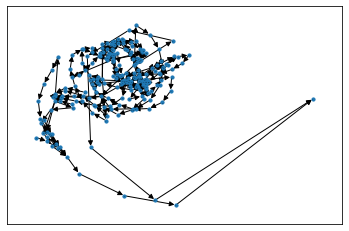

In [18]:
nx.draw_networkx(return_graph, node_size=10, font_size=1)

In [19]:
for curid in list(return_graph.nodes):
    print(return_graph.nodes[curid])
    print('*'*70)
    
netsum = 0
for curid in list(return_graph.nodes):
    net_mem = return_graph.nodes[curid]['persistent_memory'] + return_graph.nodes[curid]['output_memory'][0]
    netsum = netsum + net_mem
netsum

{'model': 'Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)', 'name': 'Conv2d', 'weight': 0.4935900370279948, 'reverse_weight': 0.08889973958333332, 'id': 3, 'topo_order': 3, 'temporary_memory': 133632, 'persistent_memory': 3456, 'output_memory': [90935296.0], 'output_tensors': 90935296.0, 'colocation_group': ''}
**********************************************************************
{'model': 'BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)', 'name': 'BatchNorm2d', 'weight': 0.874010721842448, 'reverse_weight': 0.06598307291666666, 'id': 8, 'topo_order': 8, 'temporary_memory': 0, 'persistent_memory': 256, 'output_memory': [90935296.0], 'output_tensors': 90935296.0, 'colocation_group': ''}
**********************************************************************
{'model': 'Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)', 'name': 'Conv2d', 'weight': 1.5896002451578775, 'reverse_weight': 0.09422200520833332, 'id': 10, 'topo_order': 1

2821595744.0

In [20]:
available_devices = range(args.gpu_num)
available_device_list = {k:device_list[k] for k in available_devices}
DEVICE_GRAPH_MULTIPLE = create_device_graph(available_device_list)

In [21]:
with torch.no_grad():
    placed_op_graph = m_sct(return_graph, DEVICE_GRAPH_MULTIPLE)

2021-09-21 15:25:27,037 - m_sct_v1:157 - INFO - Start LP solver.


Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 1585            
  Cones                  : 0               
  Scalar variables       : 460             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 159
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimizatio

2021-09-21 15:25:27,121 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 235.404614
2021-09-21 15:25:27,123 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5
2021-09-21 15:25:27,127 - m_sct:143 - INFO - # favorite child: 171
2021-09-21 15:25:27,128 - m_sct:144 - INFO - # favorite child changes: 0


Available mem:  8000000000
Op memory: 91072384.0
Available mem:  8000000000
Op memory: 4915712.0
Available mem:  8000000000
Op memory: 4915712.0
Available mem:  8000000000
Op memory: 4915712.0
Available mem:  8000000000
Op memory: 4915712.0
0
Available mem:  8000000000
Op memory: 4915712.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 4915712.0
True
Available mem:  8000000000
Op memory: 4915712.0
********************
Device id:  0
Memory limit:  8000000000
Availale memory:  8000000000
Conv2d(384, 384, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)  :  1769472
Available mem:  7995084800.0
Op memory: 91072384.0
Available mem:  7995084800.0
Op memory: 4915712.0
Available mem:  7995084800.0
Op memory: 4915712.0
Available mem:  7995084800.0
Op memory: 4915712.0
Available mem:  7995084800.0
Op memory: 91072384.0
Available mem:  7995084800.0
Op memory: 4915712.0
Available mem:  7995084800.0
Op memory: 4915712.0
Available mem:  

Availale memory:  7932345088.0
BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)  :  768
Available mem:  7932344320.0
Op memory: 45158400.0
Available mem:  7932344320.0
Op memory: 45158400.0
0
Available mem:  7932344320.0
Op memory: 45158400.0
Checking placement***************************************
Available mem:  7932344320.0
Op memory: 45158400.0
True
Available mem:  7932344320.0
Op memory: 45158400.0
********************
Device id:  0
Memory limit:  8000000000
Availale memory:  7932344320.0
_concatenateLayer()  :  0
Available mem:  7932344320.0
Op memory: 10116608.0
Available mem:  7932344320.0
Op memory: 10116608.0
Available mem:  7932344320.0
Op memory: 10116608.0
Available mem:  7932344320.0
Op memory: 7589376.0
0
Available mem:  7932344320.0
Op memory: 7589376.0
Checking placement***************************************
Available mem:  7932344320.0
Op memory: 7589376.0
True
Available mem:  7932344320.0
Op memory: 7589376.0
********************
Devi

Available mem:  7936775808.0
Op memory: 76091392.0
Checking placement***************************************
Available mem:  7936775808.0
Op memory: 76091392.0
True
Available mem:  7936775808.0
Op memory: 76091392.0
********************
Device id:  0
Memory limit:  8000000000
Availale memory:  7936775808.0
Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)  :  221184
Available mem:  7931537024.0
Op memory: 15053568.0
Available mem:  7931537024.0
Op memory: 15053568.0
0
Available mem:  7931537024.0
Op memory: 15053568.0
Checking placement***************************************
Available mem:  7931537024.0
Op memory: 15053568.0
True
Available mem:  7931537024.0
Op memory: 15053568.0
********************
Device id:  0
Memory limit:  8000000000
Availale memory:  7931537024.0
BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)  :  768
Available mem:  7931536256.0
Op memory: 88784896.0
Available mem:  7931536256.0
Op memory: 88784896.0
0

Op memory: 7104000.0
********************
Device id:  0
Memory limit:  8000000000
Availale memory:  7925388416.0
BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)  :  1536
Available mem:  7925386880.0
Op memory: 7694336.0
Available mem:  7925386880.0
Op memory: 26362368.0
Available mem:  7925386880.0
Op memory: 26362368.0
Available mem:  7925386880.0
Op memory: 7694336.0
Available mem:  7925386880.0
Op memory: 26362368.0
Available mem:  7925386880.0
Op memory: 26362368.0
0
Available mem:  7925386880.0
Op memory: 26362368.0
Checking placement***************************************
Available mem:  7925386880.0
Op memory: 26362368.0
True
Available mem:  7925386880.0
Op memory: 26362368.0
********************
Device id:  0
Memory limit:  8000000000
Availale memory:  7925386880.0
Conv2d(128, 128, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3), bias=False)  :  458752
Available mem:  7924928128.0
Op memory: 7694336.0
Available mem:  7924928128.0
Op memory: 26

Op memory: 7104000.0
True
Available mem:  7927386496.0
Op memory: 7104000.0
********************
Device id:  0
Memory limit:  8000000000
Availale memory:  7927386496.0
BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)  :  1536
Available mem:  7927384960.0
Op memory: 33792512.0
Available mem:  7927384960.0
Op memory: 33792512.0
0
Available mem:  7927384960.0
Op memory: 33792512.0
Checking placement***************************************
Available mem:  7927384960.0
Op memory: 33792512.0
True
Available mem:  7927384960.0
Op memory: 33792512.0
********************
Device id:  0
Memory limit:  8000000000
Availale memory:  7927384960.0
Conv2d(160, 160, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0), bias=False)  :  716800
Available mem:  7926668160.0
Op memory: 5920000.0
Available mem:  7926668160.0
Op memory: 5920000.0
0
Available mem:  7926668160.0
Op memory: 5920000.0
Checking placement***************************************
Available mem:  7926668160.0


Available mem:  7921226880.0
Op memory: 7104000.0
Available mem:  7921226880.0
Op memory: 7104000.0
0
Available mem:  7921226880.0
Op memory: 7104000.0
Checking placement***************************************
Available mem:  7921226880.0
Op memory: 7104000.0
True
Available mem:  7921226880.0
Op memory: 7104000.0
********************
Device id:  0
Memory limit:  8000000000
Availale memory:  7921226880.0
BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)  :  1536
Available mem:  7921225344.0
Op memory: 7104000.0
Available mem:  7921225344.0
Op memory: 7104000.0
Available mem:  7921225344.0
Op memory: 7104000.0
Available mem:  7921225344.0
Op memory: 7104000.0
Available mem:  7921225344.0
Op memory: 41558528.0
Available mem:  7921225344.0
Op memory: 7104000.0
Available mem:  7921225344.0
Op memory: 7104000.0
Available mem:  7921225344.0
Op memory: 41558528.0
0
Available mem:  7921225344.0
Op memory: 41558528.0
Checking placement******************************

BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)  :  1536
Available mem:  7899863680.0
Op memory: 9928704.0
Available mem:  7899863680.0
Op memory: 7104000.0
Available mem:  7899863680.0
Op memory: 9928704.0
Available mem:  7899863680.0
Op memory: 7104000.0
Available mem:  7899863680.0
Op memory: 41558528.0
Available mem:  7899863680.0
Op memory: 9928704.0
Available mem:  7899863680.0
Op memory: 7104000.0
Available mem:  7899863680.0
Op memory: 41558528.0
0
Available mem:  7899863680.0
Op memory: 7104000.0
Checking placement***************************************
Available mem:  7899863680.0
Op memory: 7104000.0
True
Available mem:  7899863680.0
Op memory: 7104000.0
********************
Device id:  0
Memory limit:  8000000000
Availale memory:  7899863680.0
BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)  :  1536
Available mem:  7899862144.0
Op memory: 9928704.0
Available mem:  7899862144.0
Op memory: 41558528.0
Available 

2021-09-21 15:25:27,658 - m_sct:172 - INFO - SCT estimated runtime: 0.000067


Availale memory:  7899862144.0
Conv2d(128, 768, kernel_size=(5, 5), stride=(1, 1), bias=False)  :  9830400
Available mem:  7890343040.0
Op memory: 41558528.0
Available mem:  7890343040.0
Op memory: 4833792.0
Available mem:  7890343040.0
Op memory: 41558528.0
Available mem:  7890343040.0
Op memory: 4833792.0
Available mem:  7890343040.0
Op memory: 104448.0
Available mem:  7890343040.0
Op memory: 41558528.0
Available mem:  7890343040.0
Op memory: 4833792.0
Available mem:  7890343040.0
Op memory: 104448.0
0
Available mem:  7890343040.0
Op memory: 41558528.0
Checking placement***************************************
Available mem:  7890343040.0
Op memory: 41558528.0
True
Available mem:  7890343040.0
Op memory: 41558528.0
********************
Device id:  0
Memory limit:  8000000000
Availale memory:  7890343040.0
Conv2d(192, 192, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3), bias=False)  :  1032192
Available mem:  7889310848.0
Op memory: 4833792.0
Available mem:  7889310848.0
Op memory: 

In [22]:
copy_p(return_graph, tester)

In [23]:
for node_id in tester.sub_module_nodes:
    print(tester.sub_module_nodes[node_id].module)
    print(tester.sub_module_nodes[node_id].p)
    print()

Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
0

BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
0

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
0

BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
0

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
0

BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
0

MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
0

Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
0

BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
0

Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
0

BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
0

MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
0

Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
0

BatchNorm2d(64, eps=0

BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
0

Conv2d(192, 192, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0), bias=False)
0

BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
0

Conv2d(192, 192, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3), bias=False)
0

BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
0

Conv2d(192, 192, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0), bias=False)
0

BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
0

Conv2d(192, 192, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3), bias=False)
0

BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
0

Conv2d(768, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
0

BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
0

_concatenateLayer()
0

Conv2d(768, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
0

BatchNo

In [24]:
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.20613289 GB
Cached:    3.78320312 GB
-----------


## Actually assign the nodes to the GPUs

In [15]:
class Assign(object):
    """
    This class actually put each submodule to the gpu it is assigned to
    """
    def __init__(self, model_wrapper):
        self.model = model_wrapper
        self.original_forwards = {}
        self.assigned = self.recur_move_layers_to_gpus(model_wrapper.model)
    
    def recur_move_layers_to_gpus(self, module):
        
        this_assigner = self
        sub_modules = module.__dict__['_modules']
        if len(sub_modules) > 0:
            for name, sub_module in sub_modules.items():
                this_assigner.recur_move_layers_to_gpus(sub_module)
        else:
            module_id = id(module)
            gpu_id = this_assigner.model.sub_module_nodes[module_id].p
    
            ### Move layers to the allotted GPUs
            # module.to(gpu_id)
            ########### FOR TESTING ##################################################
            mem0, _ = print_mem(gpu_id, cached=0, unit='B')
            module.to(gpu_id)
            mem1, _ = print_mem(gpu_id, cached=0, unit='B')
            print("Module:              ", module)
            print("GPU:                 ", gpu_id)
            print("Memory change:       ", mem1-mem0)
            print("Layer size:          ", estimate_model_size(module, unit='B', to_print=False))
            print("Net memory occupied: ", mem1)
            print("*"*50)
            #########################################################################
            
            this_assigner.original_forwards[module_id] = module.forward

            def modified_forward(self, *inputs):
                #print(self)
                #print(gpu_id)
                #print('*'*50)
                input_list = list(inputs)
                for i, inp in enumerate(input_list):
                    if isinstance(inp, torch.Tensor):
                        #print("Getting input from ", inp.get_device(), " to ", gpu_id)
                        input_list[i] = inp.to(gpu_id)
                    else:
                        print("Input not a Tensor!") ## Fix this
                inputs = tuple(input_list)
                output = this_assigner.original_forwards[module_id](*inputs) 
                # id(self) = module_id since forward is method of a module
                return output

            module.forward =  modified_forward.__get__(module, module.__class__)  

In [15]:
Assign(tester)

NameError: name 'tester' is not defined

In [27]:
inp_size = (int(args.batch_size),) + inp_size  # Concatenate the batch size

In [28]:
### Forward only run

time2 = []

for _ in range(50):
    inp   = torch.rand(inp_size)
    torch.cuda.synchronize(0); torch.cuda.synchronize(1)
    start = time.time()
    with torch.no_grad():
    #if 1:
        output = tester.model(inp)
    torch.cuda.synchronize(0); torch.cuda.synchronize(1)
    end = time.time()
    time2.append(1000*(end-start))

print("Mean time taken:", np.mean(time2[10:]))
mean_native = np.mean(time2[10:])


Mean time taken: 73.49387407302856


In [29]:
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.2046032 GB
Cached:    1.23242188 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    3.78320312 GB
-----------


## Benchmark Single GPU RUN 

In [30]:
#model = sm.toyToyModel(factor=3)
#inp_size = (args.batch_size, 3, 299, 299)

#model = sm.linearModel(factor=3)
#inp_size = (args.batch_size, 1, 10000)

#model = sm.parallelToyModel(factor=3)
#inp_size = (args.batch_size, 3, 299, 299)

#model = sm.toyModel(factor=1)
#inp_size = (args.batch_size, 3, 299, 299)

model = inception_modified.inception_v3(pretrained=True)
inp_size = (int(args.batch_size), 3, 299, 299)

In [31]:
### Forward only run
model = model.to(1)
time2 = []

for _ in range(50):
    inp   = torch.rand(inp_size).to(1)
    torch.cuda.synchronize(0); torch.cuda.synchronize(1)
    start = time.time()
    with torch.no_grad():
    #if 1:
        output = model(inp)
    torch.cuda.synchronize(0); torch.cuda.synchronize(1)
    end = time.time()
    time2.append(1000*(end-start))

print("Mean time taken:", np.mean(time2[10:]))
mean_native = np.mean(time2[10:])

Mean time taken: 65.67983627319336


## Becnhmark

In [16]:
class _concatenateLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, *x):
        return torch.cat(x, 1)
    
class _squeezeLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.squeeze()

In [17]:
class TwoLayerLinearModel(nn.Module):

    def __init__(self, factor: int = 1) -> None:
        #super(TwoLayerLinearModel, self).__init__()  # syntax in python2, works in python3
        # Explained here: https://stackoverflow.com/questions/61288224/why-not-super-init-model-self-in-pytorch
        super().__init__() # python 3 syntax
        
        self.factor = factor
        self.linear1N = 512*self.factor
        self.linear2N = 2048*self.factor
        self.linear3N = 1024*self.factor
        self.linear4N = 2*self.linear3N
        self.linear5N = 512*self.factor

        self.squeeze = _squeezeLayer()
        self.fc1 = nn.Linear(self.linear1N, self.linear2N)
        self.fc2a = nn.Linear(self.linear2N, self.linear3N)
        self.fc2b = nn.Linear(self.linear2N, self.linear3N)
        self.concatenate = _concatenateLayer()
        self.fc3 = nn.Linear(self.linear4N, self.linear5N)
        self.fc4 = nn.Linear(self.linear5N, self.linear5N)
        

    def forward(self, x):
        x = self.squeeze(x)
        x = self.fc1(x)
        xb = self.fc2b(x)
        xa = self.fc2a(x)
        y = self.concatenate(xa,xb)
        y = self.fc3(y)
        y = self.fc4(y)
        return y

In [18]:
# Ensure these settings:
# factor = 5
# prof_gpu_id = 3
# prof_rounds = 40
# gpu_num = 2


factor = 5
inp_size = (1,512*factor)

model = TwoLayerLinearModel(factor)

print(model)


#model = sm.parallelToyModel(factor=3)
#inp_size = (3, 299, 299)


TwoLayerLinearModel(
  (squeeze): _squeezeLayer()
  (fc1): Linear(in_features=2560, out_features=10240, bias=True)
  (fc2a): Linear(in_features=10240, out_features=5120, bias=True)
  (fc2b): Linear(in_features=10240, out_features=5120, bias=True)
  (concatenate): _concatenateLayer()
  (fc3): Linear(in_features=10240, out_features=2560, bias=True)
  (fc4): Linear(in_features=2560, out_features=2560, bias=True)
)
Profiling started ********************
--> Module name:  _squeezeLayer()
--> Module name:  Linear(in_features=2560, out_features=10240, bias=True)
--> Module name:  Linear(in_features=10240, out_features=5120, bias=True)
--> Module name:  Linear(in_features=10240, out_features=5120, bias=True)
--> Module name:  _concatenateLayer()
--> Module name:  Linear(in_features=10240, out_features=2560, bias=True)
--> Module name:  Linear(in_features=2560, out_features=2560, bias=True)


/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128, 128])) that is different to the input size (torch.Size([128, 2560])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/cuda/memory.py:263: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.c

make_dot started ********************
Dealing with this variable: <AddmmBackward object at 0x7fd12c524940>
Dealing with this variable: <AddmmBackward object at 0x7fd0d40f7da0>
Dealing with this variable: <CatBackward object at 0x7fd12c50ccc0>
Dealing with this variable: <AddmmBackward object at 0x7fd0db595f60>
Dealing with this variable: <AddmmBackward object at 0x7fd0db5959b0>
Dealing with this variable: <SqueezeBackward0 object at 0x7fd0db595e80>
Dealing with this variable: <TBackward object at 0x7fd0db595eb8>
Dealing with this variable: <TBackward object at 0x7fd0db5956d8>
Dealing with this variable: <AddmmBackward object at 0x7fd0db5955c0>
Dealing with this variable: <AddmmBackward object at 0x7fd0db5959b0>
Dealing with this variable: <TBackward object at 0x7fd0db595438>
Dealing with this variable: <TBackward object at 0x7fd12c50ce10>
Dealing with this variable: <TBackward object at 0x7fd0d40f7438>
Sort topologically ********************
Replacing sub module id ********************

In [19]:
return_graph, tester = build_graph(model, args.prof_gpu_id, args.prof_rounds, inp_size = inp_size)
available_devices = range(args.gpu_num)
available_device_list = {k:device_list[k] for k in available_devices}
DEVICE_GRAPH_MULTIPLE = create_device_graph(available_device_list)


Profiling started ********************
--> Module name:  _squeezeLayer()
--> Module name:  Linear(in_features=2560, out_features=10240, bias=True)
--> Module name:  Linear(in_features=10240, out_features=5120, bias=True)
--> Module name:  Linear(in_features=10240, out_features=5120, bias=True)
--> Module name:  _concatenateLayer()
--> Module name:  Linear(in_features=10240, out_features=2560, bias=True)
--> Module name:  Linear(in_features=2560, out_features=2560, bias=True)
make_dot started ********************
Dealing with this variable: <AddmmBackward object at 0x7fd12c524940>
Dealing with this variable: <AddmmBackward object at 0x7fd0d40cb710>
Dealing with this variable: <CatBackward object at 0x7fd0d40cb668>
Dealing with this variable: <AddmmBackward object at 0x7fd0d40cb518>
Dealing with this variable: <AddmmBackward object at 0x7fd0d40cb438>
Dealing with this variable: <SqueezeBackward0 object at 0x7fd0d40cbd68>
Dealing with this variable: <TBackward object at 0x7fd0d40cbf60>
De

In [20]:
with torch.no_grad():
    placed_op_graph = m_sct(return_graph, DEVICE_GRAPH_MULTIPLE)
copy_p(return_graph, tester)

for node_id in tester.sub_module_nodes:
    print(tester.sub_module_nodes[node_id].module)
    print(tester.sub_module_nodes[node_id].p)
    print()

    
Assign(tester)

2021-09-27 10:45:22,385 - m_sct_v1:157 - INFO - Start LP solver.


Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 47              
  Cones                  : 0               
  Scalar variables       : 15              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 2
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization 

2021-09-27 10:45:22,447 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 9.427270
2021-09-27 10:45:22,450 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5
2021-09-27 10:45:22,452 - m_sct:143 - INFO - # favorite child: 5
2021-09-27 10:45:22,454 - m_sct:144 - INFO - # favorite child changes: 0
2021-09-27 10:45:22,478 - m_sct:172 - INFO - SCT estimated runtime: 0.000010


Available mem:  8000000000
Op memory: 1310720.0
Available mem:  8000000000
Op memory: 1310720.0
Available mem:  8000000000
Op memory: 1310720.0
0
Available mem:  8000000000
Op memory: 1310720.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 1310720.0
True
Available mem:  8000000000
Op memory: 1310720.0
********************
Device id:  0
Memory limit:  8000000000
Availale memory:  8000000000
_squeezeLayer()  :  0
Available mem:  7998689280.0
Op memory: 110141440.0
Available mem:  8000000000
Op memory: 110141440.0
Available mem:  8000000000
Op memory: 110141440.0
Available mem:  7998689280.0
Op memory: 110141440.0
0
Available mem:  7998689280.0
Op memory: 110141440.0
Checking placement***************************************
Available mem:  7998689280.0
Op memory: 110141440.0
True
Available mem:  7998689280.0
Op memory: 110141440.0
********************
Device id:  0
Memory limit:  8000000000
Availale memory:  7998689280.0
Linear(in_features

In [22]:
inp_size = (int(args.batch_size),) + inp_size

times = []
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    for _ in range(200):
        torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2)
        inp   = torch.rand(inp_size)
        start = time.time()
        #with torch.no_grad():
        output = tester.model(inp)
        torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2)
        end = time.time()
        times.append(1000*(end-start))
prof.export_chrome_trace("trace.json")
    
print("Mean time taken:", np.mean(times[10:]))
print()

RuntimeError: CUDA error: CUBLAS_STATUS_INVALID_VALUE when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

In [23]:
int(args.batch_size)

128